### Recreation of a multi-plot from [Our World in Data](https://ourworldindata.org/grapher/electricity-generation-from-solar-and-wind-compared-to-coal)

The data that OWID provides is clean. It just takes a bit of re-formatting (in polars this time), to allow me to plot it.

I explored a bunch of methods that I hadn't really used before with Matplotlib. In fact, I was surprised that providing polars series to the library was accepted in the first place.


![Plot recreation](002%20OWID%20img.png)

In [220]:
import polars as pl

source = "./electricity-generation-from-solar-and-wind-compared-to-coal.csv"

df = pl.read_csv(source)

In [221]:
# The data provided is for more than just these 6 countries and the years, but to re-create the plot I filtered the data.
# I created separate DataFrames for the different energy sources. I was unsure how to create a subplots with separate lines.

locations = ["United States", "United Kingdom", "France", "Canada", "Germany", "Italy"]

data_sw = (df
 .select(["Entity", "Year", "Electricity from solar and wind - TWh"])
 .filter((pl.col("Year") >= 1990) & (pl.col("Entity").is_in(locations)))
 .pivot(index="Year", columns="Entity", values="Electricity from solar and wind - TWh")
)

data_c = (df
 .select(["Entity", "Year", "Electricity from coal - TWh"])
 .filter((pl.col("Year") >= 1990) & (pl.col("Entity").is_in(locations)))
 .pivot(index="Year", columns="Entity", values="Electricity from coal - TWh")
)

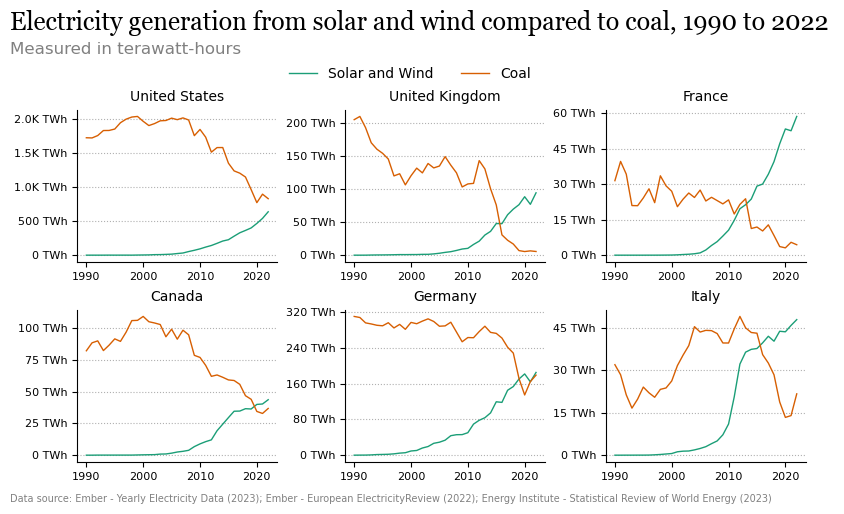

In [222]:
import matplotlib.pyplot as plt

# Function for custom format yticks
def units(x, pos):
    """The two arguments are the value and tick position."""
    if x >= 1000:
        return f'{x/1000:1.1f}K TWh'
    else:
        return f'{x:1.0f} TWh'
    
axd = plt.figure(layout="constrained", figsize=(8,4)).subplot_mosaic(
    """
    ABC
    DEF
    """
)

plots = ["A", "B", "C", "D", "E", "F"]

for location, plot in zip(locations, plots):
    line1 = axd[plot].plot(data_sw["Year"], data_sw[location], color="#1b9e77", label="Solar and Wind", linewidth=1)
    line2 = axd[plot].plot(data_c["Year"], data_c[location], color="#d75f02", label="Coal", linewidth=1)
    axd[plot].set_title(location, fontdict={"fontsize": 10})
    axd[plot].yaxis.set_major_locator(plt.MaxNLocator(5))   # Set number of yticks
    axd[plot].yaxis.set_major_formatter(units)              # Apply the "units" function defined above
    axd[plot].tick_params(axis="both", labelsize=8)         # Rather than "fontsize" on ticks, the parameter
                                                            # is "labelsize"
    axd[plot].spines["top"].set_visible(False)
    axd[plot].spines["right"].set_visible(False)
    axd[plot].grid(axis="y", linestyle="dotted")            # Add gridlines at the yticks, default
                                                            # is axis="both".

# figtext allows you to place text within the figure at relative positions. I found it easier
# to do this with multiple text fields than use .suptitle and try to arrange text around that.
# Using relative positions allows me to go outside of the figure (i.e. over 1 or below 0), to
# "expand" the figure.

plt.figtext(0, 1.14, 
            "Electricity generation from solar and wind compared to coal, 1990 to 2022 ", 
            fontsize=18, ha="left",
            fontdict={'fontname': 'Georgia'})

plt.figtext(0, 1.08, 
            "Measured in terawatt-hours", 
            fontsize=12, ha="left", 
            fontdict={"color": "grey"})

plt.figtext(0, -0.04, 
            "Data source: Ember - Yearly Electricity Data (2023); Ember - European Electricity" \
            "Review (2022); Energy Institute - Statistical Review of World Energy (2023)",
            fontsize=7, ha='left', 
            fontdict={"color": "grey"})

# Add legend with adjusted position
handles, labels = axd["A"].get_legend_handles_labels() 

plt.figlegend(handles, labels, 
              loc="upper center", 
              bbox_to_anchor=(0.5, 1.08), 
              ncols=2,
              frameon=False)

plt.show()

In [223]:
# https://matplotlib.org/stable/api/figure_api.html#matplotlib.figure.Figure.subplot_mosaic
# https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.figlegend.html
# https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.get_legend_handles_labels.html
# https://matplotlib.org/stable/gallery/ticks/custom_ticker1.html
# https://stackoverflow.com/questions/6390393/how-to-change-tick-label-font-size
# https://stackoverflow.com/questions/42758897/change-line-width-of-lines-in-matplotlib-pyplot-legend